# Face Verification Project

<div>
<a href="https://colab.research.google.com/github/LeNguyenGiaBao/face_verification_demo/blob/master/face_verification_flow.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Project Overview
How does the computer know 2 pictures are the same person?

You are the person, and you can determine that 2 pictures are the same person, or 2 different people. So how can the machine have that ability, in the time of digization.

This application applys the archivement in Computer Vision, using Convolutional Neural Network and Cosine Similarity to verify 2 picture.

Technical Step:

- Face Detection
- Face Alignment
- Feature Extraction
- Cosine Similarity

Model:

- RetinaFace for Face Detection
- ArcFace for Face Extraction

# Data Analysis

The dataset using in this project is [Labeled Faces In The Wild (LFW)](http://vis-www.cs.umass.edu/lfw/), an offical benchmark dataset in many face verification and face recognition fields. LFW is collected, labeled and publiced in IEEE Computer Vision and Pattern Recognition 2007 by University of Massachusetts, Amherst

LFW includes **13233** images, **5749** classes, and **1680** classes have more than 2 images, image size 250x250 pixel. In a image could have many faces.

Faces in LFW is in many conditions, like positions, poses, brighness, hue, image quality, ages, genders, ...

## Data Wrangling

In [2]:
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
! tar xzf lfw.tgz

--2022-12-06 13:48:11--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz.1’

lfw.tgz.1           100%[===================>] 172.20M  54.9MB/s    in 3.3s    

2022-12-06 13:48:14 (51.8 MB/s) - ‘lfw.tgz.1’ saved [180566744/180566744]



# Strategy
Using Neural network for face detection, feature extraction to get feature of face, calculate the similarity of 2 faces of the same person and 2 faces of 2 different people. In a large dataset, I could find the threshold for acceptance 

Model: 

- Face Detection
- Face Alignment
- Feature Extraction
- Cosine Similarity

# Expectation
Find the threshold to accept a similarity of 2 face images

The threshold is achieved with high accuracy, precision, recall and F1 score

The threshod is expected seperately similarity of same person and different person

# Metric

There are many diferrent similarity methods, like Cosine Distance, Euclidean Distance, but I choose Cosine Similarity, because 2 reasons:

- Cosine Similarity Score is in range [-1, 1], different with Euclidean Distance in range [0, 4], and no method to convert them linearly
- The higher Cosine Similarity, the higher similarity of 2 embedding, opposite with Cosine Distance
- My experiment shows that the Cosine Similarity in Face Embedding is only in range [0, 1], suitable for calculating, it likes Binary Classification

In [3]:
%%capture
!pip install insightface
!pip install onnxruntime

In [26]:
import glob
import math
import shutil

import cv2
import insightface
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from insightface.app import FaceAnalysis
from sklearn.metrics import precision_recall_curve

# Exploratory Data Analysis

In [5]:
dataset_path = glob.glob('./lfw/*/*.jpg')

In [6]:
# num of images
len(glob.glob('./lfw/*/*.jpg'))

13233

In [7]:
# num of classes 
len(glob.glob('./lfw/*/'))

5749

(array([5.74e+03, 4.00e+00, 3.00e+00, 0.00e+00, 1.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([  1. ,  53.9, 106.8, 159.7, 212.6, 265.5, 318.4, 371.3, 424.2,
        477.1, 530. ]),
 <a list of 10 Patch objects>)

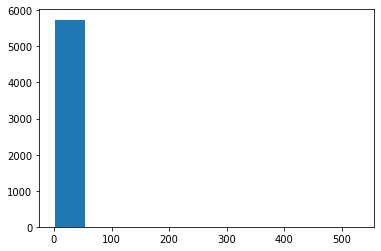

In [8]:
dataset_path = './lfw/*/'
num_images_distribution = []
for folder in glob.glob(dataset_path):
    file_paths = folder + '*.*' 
    num_images_of_person = len(glob.glob(file_paths)) 
    num_images_distribution.append(num_images_of_person)

plt.hist(num_images_distribution)


(array([5.591e+03, 9.600e+01, 2.800e+01, 1.500e+01, 7.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <a list of 10 Patch objects>)

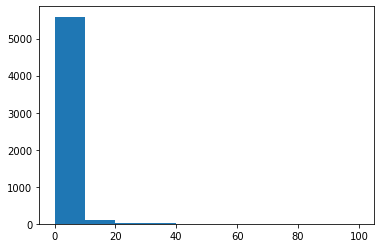

In [9]:
plt.hist(num_images_distribution, range=[0,100])


Text(0, 0.5, 'amount')

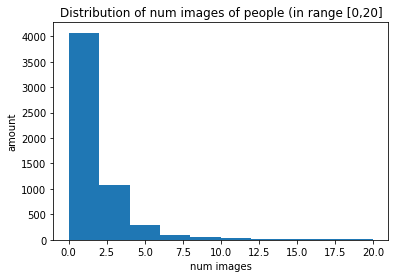

In [10]:
plt.hist(num_images_distribution, range=[0,20])
plt.title("Distribution of num images of people (in range [0,20]")
plt.xlabel("num images")
plt.ylabel("amount")

In [11]:
# clean data: remove person has 1 image
dataset_path = './lfw/*/'
for folder in glob.glob(dataset_path):
    file_paths = folder + '*.*' # get all file with any extension
    if len(glob.glob(file_paths)) == 1: # remove folder has 1 image
        shutil.rmtree(folder)

print('Total people:', len(glob.glob(dataset_path)))
print('Total images: ', len(glob.glob(dataset_path+'*.*')))

Total people: 1680
Total images:  9164


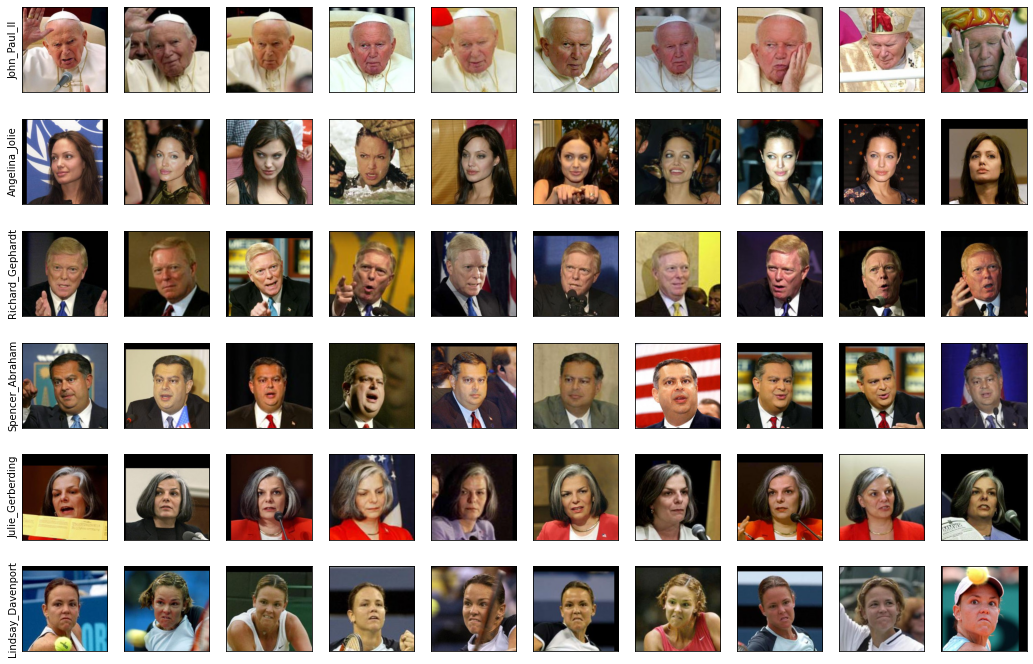

In [17]:
rows = 6
cols = 10
k=-1

fig, axs = plt.subplots(rows, cols, figsize=(18,12))
dataset_path =  glob.glob('./lfw/*/')
for i in range(500):
    name = dataset_path[i].split('/')[-2].replace('/','')
    paths = glob.glob(dataset_path[i]+'*.*')
    num_paths = len(paths)

    if num_paths < cols: continue
    max_loop = min(num_paths, cols)
    k += 1
    if k == rows: break

    for j in range(max_loop):
        axs[k,0].set_ylabel(name)

        axs[k,j].set_xticks([])
        axs[k,j].set_yticks([])
        img = mpimg.imread(paths[j])
        imgplot = axs[k,j].imshow(img)

# Modeling: Face Detection and Feature Extraction

- RetinaFace for Face Detection
- ArcFace for Face Extraction

Using Insightface buildin library

In [18]:
model_name = 'buffalo_l'
app = FaceAnalysis(name=model_name, allowed_modules=['detection', 'recognition']) 
app.prepare(ctx_id=0, det_size=(640, 640))

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:42<00:00, 6615.10KB/s]
/usr/local/lib/python3.8/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:54: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


# Data Processing:

- Get all faces in an image, include the bounding box, landmark of face by RetinaFace model
- Select the most central face in the image, using the position of bounding box of that face
- Get the embedding of the most central face
- Normalization the embedding by L2 Normalization

# Statistics for find the acceptance threshold

With a person in 1680 people, I will:

- Get randomly 2 images of him, named img_1 and img_2
- Calculate embedding of 2 image, named emb_1 and emb_2, respectively
- Append into array emb_A and emb_B

After looping all people, I wil have 2 array emb_A and emb_B, with 1680\*d dimension, with d is the dimension of embedding

To find the threshold, I do:

- Calculate the similarity of each emb in emb_A with corresponding emb in emb_B, the result array with 1680\*1680 dimension
- Create the label array
- Calculate the Precision, Recall and F1 Score of the similarity and the label
- At the similarity score that has greatest F1 Score, it is the threshold

In [25]:
def l2_normalize(x):
    return x / np.sqrt(np.sum(np.multiply(x, x)))

def get_distance_from_center(x1, y1, x2, y2):
    x_center = x1 + (x2-x1)/2
    y_center = y1 + (y2-y1)/2

    p_x_center = 250/2
    p_y_center = 250/2

    dis = math.sqrt((p_x_center-x_center)**2+(p_y_center-y_center)**2)

    return dis

In [20]:
dataset_path = './lfw/*/'
emb_A = []
emb_B = []
emb_A_norm = []
emb_B_norm = []

for folder in tqdm.tqdm(glob.glob(dataset_path)):
    paths = glob.glob(folder + '*.*')[:2]
    path1 = paths[0]
    path2 = paths[1]

    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)

    faces1 = app.get(img1)
    faces2 = app.get(img2)

    if faces1 == [] or faces2 == []:
      continue

    # get nearest face from center. bbox: x1 y1 x2 y2
    face1 = sorted(faces1, key=lambda x:get_distance_from_center(x['bbox'][0], x['bbox'][1], x['bbox'][2], x['bbox'][3]))[0]
    face2 = sorted(faces2, key=lambda x:get_distance_from_center(x['bbox'][0], x['bbox'][1], x['bbox'][2], x['bbox'][3]))[0]

    emb1 = face1.embedding
    emb2 = face2.embedding

    emb1_norm = l2_normalize(emb1)
    emb2_norm = l2_normalize(emb2)

    emb_A.append(emb1)
    emb_B.append(emb2)
    emb_A_norm.append(emb1_norm)
    emb_B_norm.append(emb2_norm)

array_A = np.array(emb_A)
array_B = np.array(emb_B)

np.save('lfw_retina_arc_center_face_a.npy', array_A)
np.save('lfw_retina_arc_center_face_b.npy', array_B)

print()
print("array_A shape", array_A.shape)
print("array_B shape", array_B.shape)

100%|██████████| 1680/1680 [59:52<00:00,  2.14s/it]


array_A shape (1672, 512)
array_B shape (1672, 512)


In [23]:
norm_array_A = np.linalg.norm(array_A, axis=1)
norm_array_B = np.linalg.norm(array_B, axis=1)

norm_array_A = norm_array_A.reshape(-1, 1)
norm_array_B = norm_array_B.reshape(1, -1)

mul = np.dot(array_A, array_B.T)
mul_norm = np.dot(norm_array_A, norm_array_B)

cosine_similarity = mul / mul_norm

print(cosine_similarity.shape)
print(cosine_similarity)

(1672, 1672)
[[ 0.7694362   0.00536603 -0.03637935 ...  0.0372042  -0.04111386
   0.01907674]
 [ 0.03450516  0.585885   -0.02321564 ...  0.04250584  0.07141454
   0.01116782]
 [ 0.03299728 -0.05888586  0.7976986  ...  0.0100894  -0.00760853
   0.01161481]
 ...
 [ 0.03810863 -0.05466076  0.01838253 ...  0.7642664   0.03729136
   0.01974685]
 [ 0.01825104 -0.05381516  0.03241767 ...  0.03149322  0.678118
  -0.1924996 ]
 [ 0.01456572 -0.0198344   0.01799321 ...  0.03184648 -0.11005661
   0.9054491 ]]


Threshold shape (1359740,)
0.36786744


<ipython-input-24-0a2ce014aba4>:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('lfw_retina_arc_cosine_similarity_curve_center_face.png')
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


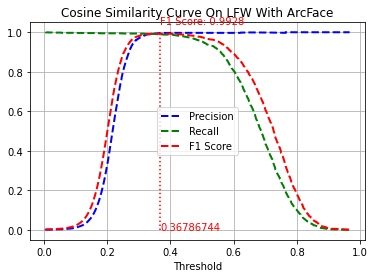

In [24]:
y_pred = cosine_similarity.flatten()
y_pred = np.where(y_pred>1, 1, y_pred)
y_label = np.eye(N=cosine_similarity.shape[0], dtype=int).flatten()

precisions, recalls, thresholds = precision_recall_curve(y_label, y_pred)
f1_score = (2*precisions*recalls)/(precisions+recalls+1e-6)

print("Threshold shape", thresholds.shape)
threshold_index = np.argmax(f1_score)
threshold_value = thresholds[threshold_index]
precision_value = precisions[threshold_index]
recall_value = recalls[threshold_index]
f1_score_value = f1_score[threshold_index]

print(threshold_value)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
plt.plot(thresholds, f1_score[:-1], "r--", label="F1 Score", linewidth=2)

# line at threshold value
plt.plot([threshold_value, threshold_value], [0,1], "r:")   

plt.text(threshold_value, 0, threshold_value, c='r')  
plt.text(threshold_value, f1_score_value+0.05, "F1 Score: {:.4f}".format(f1_score_value), c='r')  

plt.legend() 
plt.grid(True)
plt.xlabel("Threshold")
plt.title("Cosine Similarity Curve On LFW With ArcFace")
plt.savefig('lfw_retina_arc_cosine_similarity_curve_center_face.png')
plt.show()

# Results

Result in LFW dataset

The highest F1 Score is 0.9928, at similarity score 0.36786744, as acceptance threshold

Compare with the [ArcFace paper](https://arxiv.org/abs/1801.07698), the verification result is 0.9953 at loss function 0.5

Why difference about the paper result and the experiment result?

By me: There are some faces choosen wrong by my Face detection code to get face: need to get face manually to get the accurate result

# Conclusion

By this project, I have built:

- A full statistics about LFW dataset.
- The complete flow to find the threshold of acceptance in LFW dataset, compare it with the public paper, and explain the wrong between them.

# Improvement:

- Implement the flow with another metrics, like Euclidean distance, ...
- Implement the Siamese Networks to transfer learning, using non-linear approach
- Implement on another face dataset, like WIDER Face, VGG Face, ...

### Citation

```
@TechReport{LFWTech,
    author =       {Gary B. Huang and Manu Ramesh and Tamara Berg and
                    Erik Learned-Miller},
    title =        {Labeled Faces in the Wild: A Database for Studying
                    Face Recognition in Unconstrained Environments},
    institution =  {University of Massachusetts, Amherst},
    year =         2007,
    number =       {07-49},
    month =        {October}
}

@inproceedings{Deng2020CVPR,
    title = {RetinaFace: Single-Shot Multi-Level Face Localisation in the Wild},
    author = {Deng, Jiankang and Guo, Jia and Ververas, Evangelos and Kotsia, Irene and Zafeiriou, Stefanos},
    booktitle = {CVPR},
    year = {2020}
}

@inproceedings{deng2018arcface,
    title={ArcFace: Additive Angular Margin Loss for Deep Face Recognition},
    author={Deng, Jiankang and Guo, Jia and Niannan, Xue and Zafeiriou, Stefanos},
    booktitle={CVPR},
    year={2019}
}

@misc{ enwiki:1123118417,
    author = "{Wikipedia contributors}",
    title = "Cosine similarity --- {Wikipedia}{,} The Free Encyclopedia",
    year = "2022",
    url = "https://en.wikipedia.org/w/index.php?title=Cosine_similarity&oldid=1123118417",
    note = "[Online; accessed 6-December-2022]"
}

@incollection{Nguyen2011-sa,
    title     = "Cosine similarity metric learning for face verification",
    booktitle = "Computer Vision -- {ACCV} 2010",
    author    = "Nguyen, Hieu V and Bai, Li",
    publisher = "Springer Berlin Heidelberg",
    pages     = "709--720",
    series    = "Lecture notes in computer science",
    year      =  2011,
    address   = "Berlin, Heidelberg"
}
```